<a href="https://colab.research.google.com/github/dtarrio/WhatsappOpenAI/blob/main/POC_Whatsapp_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#POC api que interactúa con modelo GPT4o y con APP de Meta For Business para ofrecer comunicación con modelo a traves de Whatsapp. Alcanza con especializar al modelo para que desde Whatsapp pueda responder directamente sobre el dominio específico de la APP expuesta por Meta for Business.

**Diagrama de secuencia simplificado:**

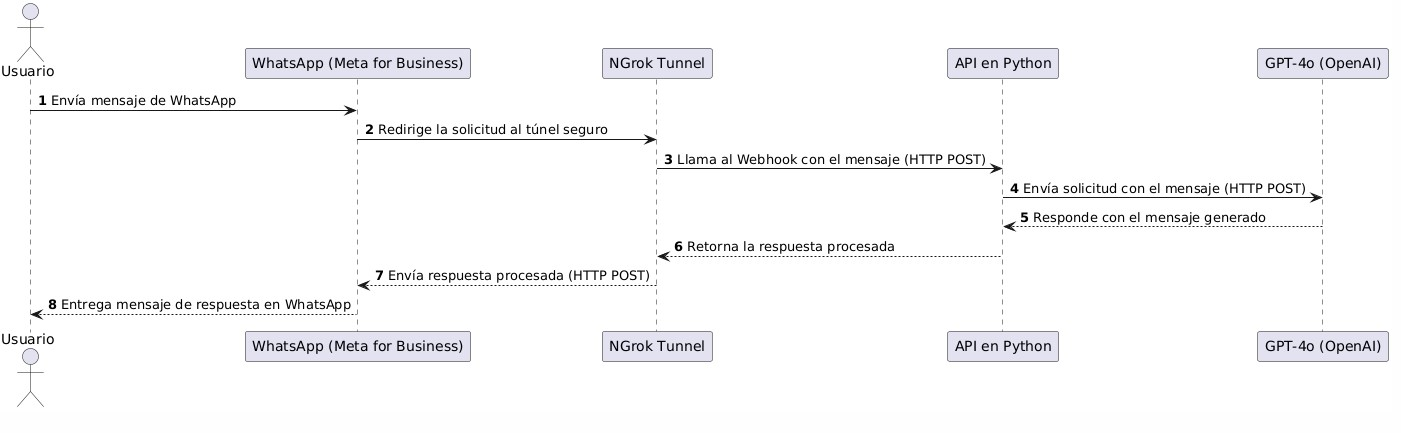


**Autor:** Diego Fernando Tarrío


2025




In [ ]:
from flask import Flask, request
import requests
import os
import threading
!pip install python-dotenv
from dotenv import load_dotenv

#cargo variables/tokens de Meta y OpenAI de archivo .env
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
NGROK_AUTHTOKEN = os.getenv("NGROK_AUTHTOKEN")

app = Flask(__name__)

#para guardar los logs en archivo porque tengo problemas para ver la salida con print al correr Flask en un thread separado:
import sys

log_file = open("logs.txt", "a")
sys.stdout = log_file


In [ ]:
!pip install pyngrok
from pyngrok import ngrok
ngrok.set_auth_token(NGROK_AUTHTOKEN)
public_url = ngrok.connect(5000).public_url
print("NGrok URL: ", public_url)

#Función para imprimir log en tiempo real, dado que Flask corre en un Thread separado

In [ ]:
def log_info(message):
  print(f"[LOG] {message}", flush=True)
  sys.stdout.flush()

# Función para envío de mensajes al Model (OpenAI)

In [ ]:
import sys

def chatgpt(prompt):

  log_info(f"Se invocará a ChatGPT con el siguiente Prompt: {prompt}")

  headers = {
    "Authorization": f"Bearer {OPENAI_API_KEY}",
    "Content-Type": "application/json"
  }
  data = {
    "model": "gpt-4o",
    "messages": [
      {"role": "user", "content": prompt}
    ]
  }
  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)

  log_info(f"Respuesta de ChatGPT: {response.json()}")

  return response.json()["choices"][0]["message"]["content"]

# Función para responder en WhatsApp

In [ ]:
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
import re #necesito una expresión regular para adecuar el número de teléfono
          # ya que me agregaba un 9 luego del código de país y eso fallaba al enviarlo hacia Meta

def send_whatsapp_message(to, message):
  url = "https://graph.facebook.com/v21.0/569854986207162/messages"
  headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
     "Content-Type": "application/json"
  }
  data = {
    "messaging_product": "whatsapp",
    "to": re.sub(r"^(\d{1,4})9(\d+)$", r"\1\2",to),
    "text": {
      "body": message,
      "preview_url": False
    }
  }

  log_info(f"Url paraa enviar a WhatsApp:{url}")
  log_info(f"Headers para enviar a WhatsApp:{headers}")
  log_info(f"Data para enviar a WhatsApp:{data}")

  requests.post(url, headers=headers, json=data)

#Función para manejar la verificación del webhook de Meta (se requiere ingresar el Verify_Token ingresado en Meta

In [ ]:
@app.route("/webhook", methods=["GET"])
def verify():
    VERIFY_TOKEN = "abc123cba321testd"
    mode = request.args.get("hub.mode")
    token = request.args.get("hub.verify_token")
    challenge = request.args.get("hub.challenge")

    if mode == "subscribe" and token == VERIFY_TOKEN:
        return challenge, 200
    else:
        return "Forbidden", 403


# Endpoint para recibir mensajes de WhatsApp


In [ ]:
@app.route('/webhook', methods=['POST'])
def webhook():
  data = request.get_json()
  if "messages" in data['entry'][0]['changes'][0]['value']:
    message = data['entry'][0]['changes'][0]['value']['messages'][0]
    sender_id = message["from"]
    text = message["text"]["body"]

    # Envía mensaje a OpenAI
    chatgpt_response = chatgpt(text)

    # Responder por WhatsApp
    send_whatsapp_message(sender_id, chatgpt_response)

  return "OK", 200

#Ejecutar Flask en un thread para que no se detenga en Colab

In [ ]:
def run_flask():

  app.run(port=5000, debug=True, use_reloader=False)

thread = threading.Thread(target=run_flask)
thread.start()

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
